# Narongkrit Khieopraphatsorn ID: 3975261346

# HW3_INF 552

## 1. Time Series Classification

An interesting task in machine learning is classification of time series. In this problem, we will classify the activities of humans based on time series obtained by a Wireless Sensor Network.

###  (a) Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/ Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\ %29 . 
### The dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity.1 Each file containis 6 time series collected from activities of the same person, which are called avg rss12, var rss12, avg rss13, var rss13, avg rss23, and var rss23. There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values.

In [38]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics, neighbors
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, Normalizer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB, MultinomialNB

### (b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [6]:
!git clone "https://github.com/Tony-nkt/inf_552.git"
# Name of Activity
activity = ["bending1", "bending2", "cycling", "lying", "sitting", "walking","standing"]
# All columns
df_test = pd.DataFrame(columns=["avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23","class"])

df_train = df_test

time_domain_feature = ['min','max','mean','median','sd','first_quart','third_quart']

df_time_test = {}
for i in range(1,7):
    for var in time_domain_feature:
        df_time_test[var+'_'+str(i)] = []
df_time_test['class'] = []

# All time feature columns 
df_time_train = {}
for i in range(1,7):
    for var in time_domain_feature:
        df_time_train[var+'_'+str(i)] = []
df_time_train['class'] = []

df_time = {}
for i in range(1,7):
    for var in time_domain_feature:
        df_time[var+'_'+str(i)] = []
df_time['class'] = []

column_feat_dict = { v:k+1  for k,v in enumerate(["avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"])} 


fatal: destination path 'inf_552' already exists and is not an empty directory.


#### cleaning the data from excel, "dataset4" from bending2 folder (format problem) and "dataset9", "dataset14" from cycling folder (contains comma) , "dataset8" from sitting folder (13500 time series column is missing). For 13500 column, I insert the data the same as the previous timestamp's data (13250).

In [7]:
def insert_tdf(df_tmp,df,df_part_tdf,df_full_tdf,var):
    column_feat_dict = { v:k+1  for k,v in enumerate(["avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"])} 
    time_domain_feature = ['min','max','mean','median','sd','first_quart','third_quart']
    for k,v in column_feat_dict.items():
        for var2 in time_domain_feature:
            if var2 == "min":
                df_part_tdf[var2+"_"+str(v)].append(df_tmp[k].min())
                df_full_tdf[var2+"_"+str(v)].append(df_tmp[k].min())
            elif var2 == "max":
                df_part_tdf[var2+"_"+str(v)].append(df_tmp[k].max())
                df_full_tdf[var2+"_"+str(v)].append(df_tmp[k].max())
            elif var2 == "mean":
                df_part_tdf[var2+"_"+str(v)].append(df_tmp[k].mean())
                df_full_tdf[var2+"_"+str(v)].append(df_tmp[k].mean())
            elif var2 == "median":
                df_part_tdf[var2+"_"+str(v)].append(df_tmp[k].median())
                df_full_tdf[var2+"_"+str(v)].append(df_tmp[k].median())
            elif var2 == "sd":
                df_part_tdf[var2+"_"+str(v)].append(df_tmp[k].std())
                df_full_tdf[var2+"_"+str(v)].append(df_tmp[k].std())
            elif var2 == "first_quart":
                df_part_tdf[var2+"_"+str(v)].append(df_tmp[k].quantile(0.25))
                df_full_tdf[var2+"_"+str(v)].append(df_tmp[k].quantile(0.25))
            elif var2 == "third_quart":
                df_part_tdf[var2+"_"+str(v)].append(df_tmp[k].quantile(0.75))
                df_full_tdf[var2+"_"+str(v)].append(df_tmp[k].quantile(0.75))
    df_part_tdf['class'].append(var)
    df_full_tdf['class'].append(var)
    
    df = df.append(df_tmp,sort=False,ignore_index=True)
    
    return df,df_part_tdf,df_full_tdf                                                              

In [8]:
def read_File(df,df_part_tdf,df_full_tdf,var,i):
    filename = "inf_552/HW03/AReM/"+var+"/dataset"+str(i)+".csv"
    if i == 4 and var == "bending2": 
        df_tmp = pd.read_csv(filename,header=4,delim_whitespace=True)
        df_tmp = df_tmp.drop("#_Columns_time",axis=1)
    else:
        df_tmp = pd.read_csv(filename,header=4)
        df_tmp = df_tmp.drop('# Columns: time',axis = 1)

    df_tmp["class"] = var
    df,df_part_tdf,df_full_tdf = insert_tdf(df_tmp,df,df_part_tdf,df_full_tdf,var)
    return df,df_part_tdf,df_full_tdf

In [9]:
for var in activity:
    if var == 'bending1' or var == "bending2":
        for i in range(1,3):
            df_test,df_time_test,df_time = read_File(df_test,df_time_test,df_time,var,i)
    else:
        for i in range(1,4):
            df_test,df_time_test,df_time = read_File(df_test,df_time_test,df_time,var,i)

for var in activity:
    if var == "bending1":
        for i in range(3,8):
            df_train,df_time_train,df_time = read_File(df_train,df_time_train,df_time,var,i)
    elif var == "bending2":
        for i in range(3,7):
            df_train,df_time_train,df_time = read_File(df_train,df_time_train,df_time,var,i)
    else:
        for i in range(4,16):
            df_train,df_time_train,df_time = read_File(df_train,df_time_train,df_time,var,i)

In [10]:
df = df_test.append(df_train,sort=False,ignore_index=True)

### c) Feature Extraction
### Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.
### i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

Minimum, maximum, mean, median, mode, standard deviation, first quartile, third quartile, inter-quartile, range

### ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [11]:
df_time = pd.DataFrame(df_time)

In [12]:
df_time.shape

(88, 43)

In [13]:
df_time

,min_1,max_1,mean_1,median_1,sd_1,first_quart_1,third_quart_1,min_2,max_2,mean_2,...,first_quart_5,third_quart_5,min_6,max_6,mean_6,median_6,sd_6,first_quart_6,third_quart_6,class
0,37.25,45.00,40.624792,40.500,1.476967,39.2500,42.0000,0.0,1.30,0.358604,...,33.0000,36.0000,0.00,1.92,0.570583,0.430,0.582915,0.0000,1.3000,bending1
1,38.00,45.67,42.812812,42.500,1.435550,42.0000,43.6700,0.0,1.22,0.372438,...,32.0000,34.5000,0.00,3.11,0.571083,0.430,0.601010,0.0000,1.3000,bending1
2,12.75,51.00,24.562958,24.250,3.737514,23.1875,26.5000,0.0,6.87,0.590833,...,20.5000,27.0000,0.00,4.97,0.700188,0.500,0.693720,0.4300,0.8700,bending2
3,0.00,42.75,27.464604,28.000,3.583582,25.5000,30.0000,0.0,7.76,0.449708,...,15.0000,20.7500,0.00,6.76,1.122125,0.830,1.012342,0.4700,1.3000,bending2
4,24.25,45.00,37.177042,36.250,3.581301,34.5000,40.2500,0.0,8.58,2.374208,...,17.9500,21.7500,0.00,9.34,2.921729,2.500,1.852600,1.5000,3.9000,cycling
5,28.75,44.75,37.561188,36.875,3.226507,35.2500,40.2500,0.0,9.91,2.080688,...,18.0000,21.5000,0.00,9.62,2.765896,2.450,1.769203,1.4100,3.7700,cycling
6,22.00,44.67,37.058708,36.000,3.710180,34.5000,40.0625,0.0,14.17,2.438146,...,16.0000,21.0000,0.00,8.55,2.983750,2.570,1.815730,1.5000,4.1500,cycling
7,23.50,30.00,27.716375,27.500,1.442253,27.0000,29.0000,0.0,1.79,0.363688,...,5.5000,10.7500,0.00,4.50,0.734271,0.710,0.613688,0.4300,1.0000,lying
8,24.75,48.33,44.182937,48.000,7.495615,48.0000,48.0000,0.0,3.11,0.101875,...,2.0000,5.5425,0.00,3.91,0.692771,0.500,0.675781,0.3225,0.9400,lying
9,48.00,48.25,48.004167,48.000,0.032038,48.0000,48.0000,0.0,0.43,0.007167,...,4.6700,10.0000,0.00,2.50,0.641229,0.500,0.388372,0.4600,0.8300,lying


### iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootstrap confidence interval for the standard deviation of each feature.

In [14]:
std_col = {}

for var in df_time.columns[:-1]:
    std_col[var] = [df_time[var].std()]

In [15]:
std_col_table = pd.DataFrame(std_col)

In [16]:
std_col_table.index = ["value"]

In [17]:
std_col_table

,min_1,max_1,mean_1,median_1,sd_1,first_quart_1,third_quart_1,min_2,max_2,mean_2,...,sd_5,first_quart_5,third_quart_5,min_6,max_6,mean_6,median_6,sd_6,first_quart_6,third_quart_6
value,9.569975,4.394362,5.335703,5.440054,1.772155,6.15359,5.138925,0.0,5.062729,1.57417,...,1.02487,6.096465,5.53172,0.045838,2.518921,1.154752,1.086474,0.517503,0.758584,1.523599


In [18]:
std_ci_table = {}
std_ci = defaultdict(list)
for var in df_time.columns[:-1]:
    tmp_resample = np.array(df_time[var])
    tmp_std_ci = []
    for i in range(20):
        tmp = resample(tmp_resample,n_samples=len(tmp_resample),random_state=i)
        tmp_std_ci.append(tmp.std())
    tmp_std_ci = sorted(tmp_std_ci)
    std_ci[var].append(tmp_std_ci)
    std_ci_table[var] = [str(tmp_std_ci[1])+'->'+str(tmp_std_ci[18])]

In [19]:
std_ci_table = pd.DataFrame(std_ci_table)

In [20]:
std_ci_table

,min_1,max_1,mean_1,median_1,sd_1,first_quart_1,third_quart_1,min_2,max_2,mean_2,...,sd_5,first_quart_5,third_quart_5,min_6,max_6,mean_6,median_6,sd_6,first_quart_6,third_quart_6
0,8.454873221133116->10.114674594309019,3.386855912968046->4.809128349602924,4.6306343836086965->5.7181843317240855,4.623180745264375->5.854829727138185,1.5949857548447568->1.8775305654234342,5.448828105332538->6.604826698984973,4.21053276211969->5.562678837720822,0.0->0.0,4.651676493691581->5.386118689290459,1.466668564994512->1.69617881236284,...,0.8397128530981319->1.188650542598251,4.974701552834373->7.297630307314865,4.692799067803772->6.466484500616512,0.0->0.06408405830567865,2.227249278053741->2.7465876180068296,1.0799967745432->1.198495317649077,1.0140447353083648->1.1261381854287622,0.48666679912189365->0.5411256618842929,0.6999692099328945->0.8004879866399665,1.4235497433769373->1.570080881370263


### iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

It will be max, mean and median. Mean and median are the average values, Max is also considered for this question.

## (d) Binary Classification Using Logistic Regression
### i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook).

In [21]:
df_time_test = pd.DataFrame(df_time_test)
df_time_train = pd.DataFrame(df_time_train)

In [22]:
df_plot_time = df_time[["mean_1","median_1","sd_1","mean_2","median_2","sd_2","mean_6","median_6","sd_6","class"]]

In [23]:
df_plot_time = df_plot_time.replace(to_replace =["bending1","bending2" ],value ="bending")
df_plot_time = df_plot_time.replace(to_replace = [var for var in activity if var != "bending1" or var != "bending2"],value="others")

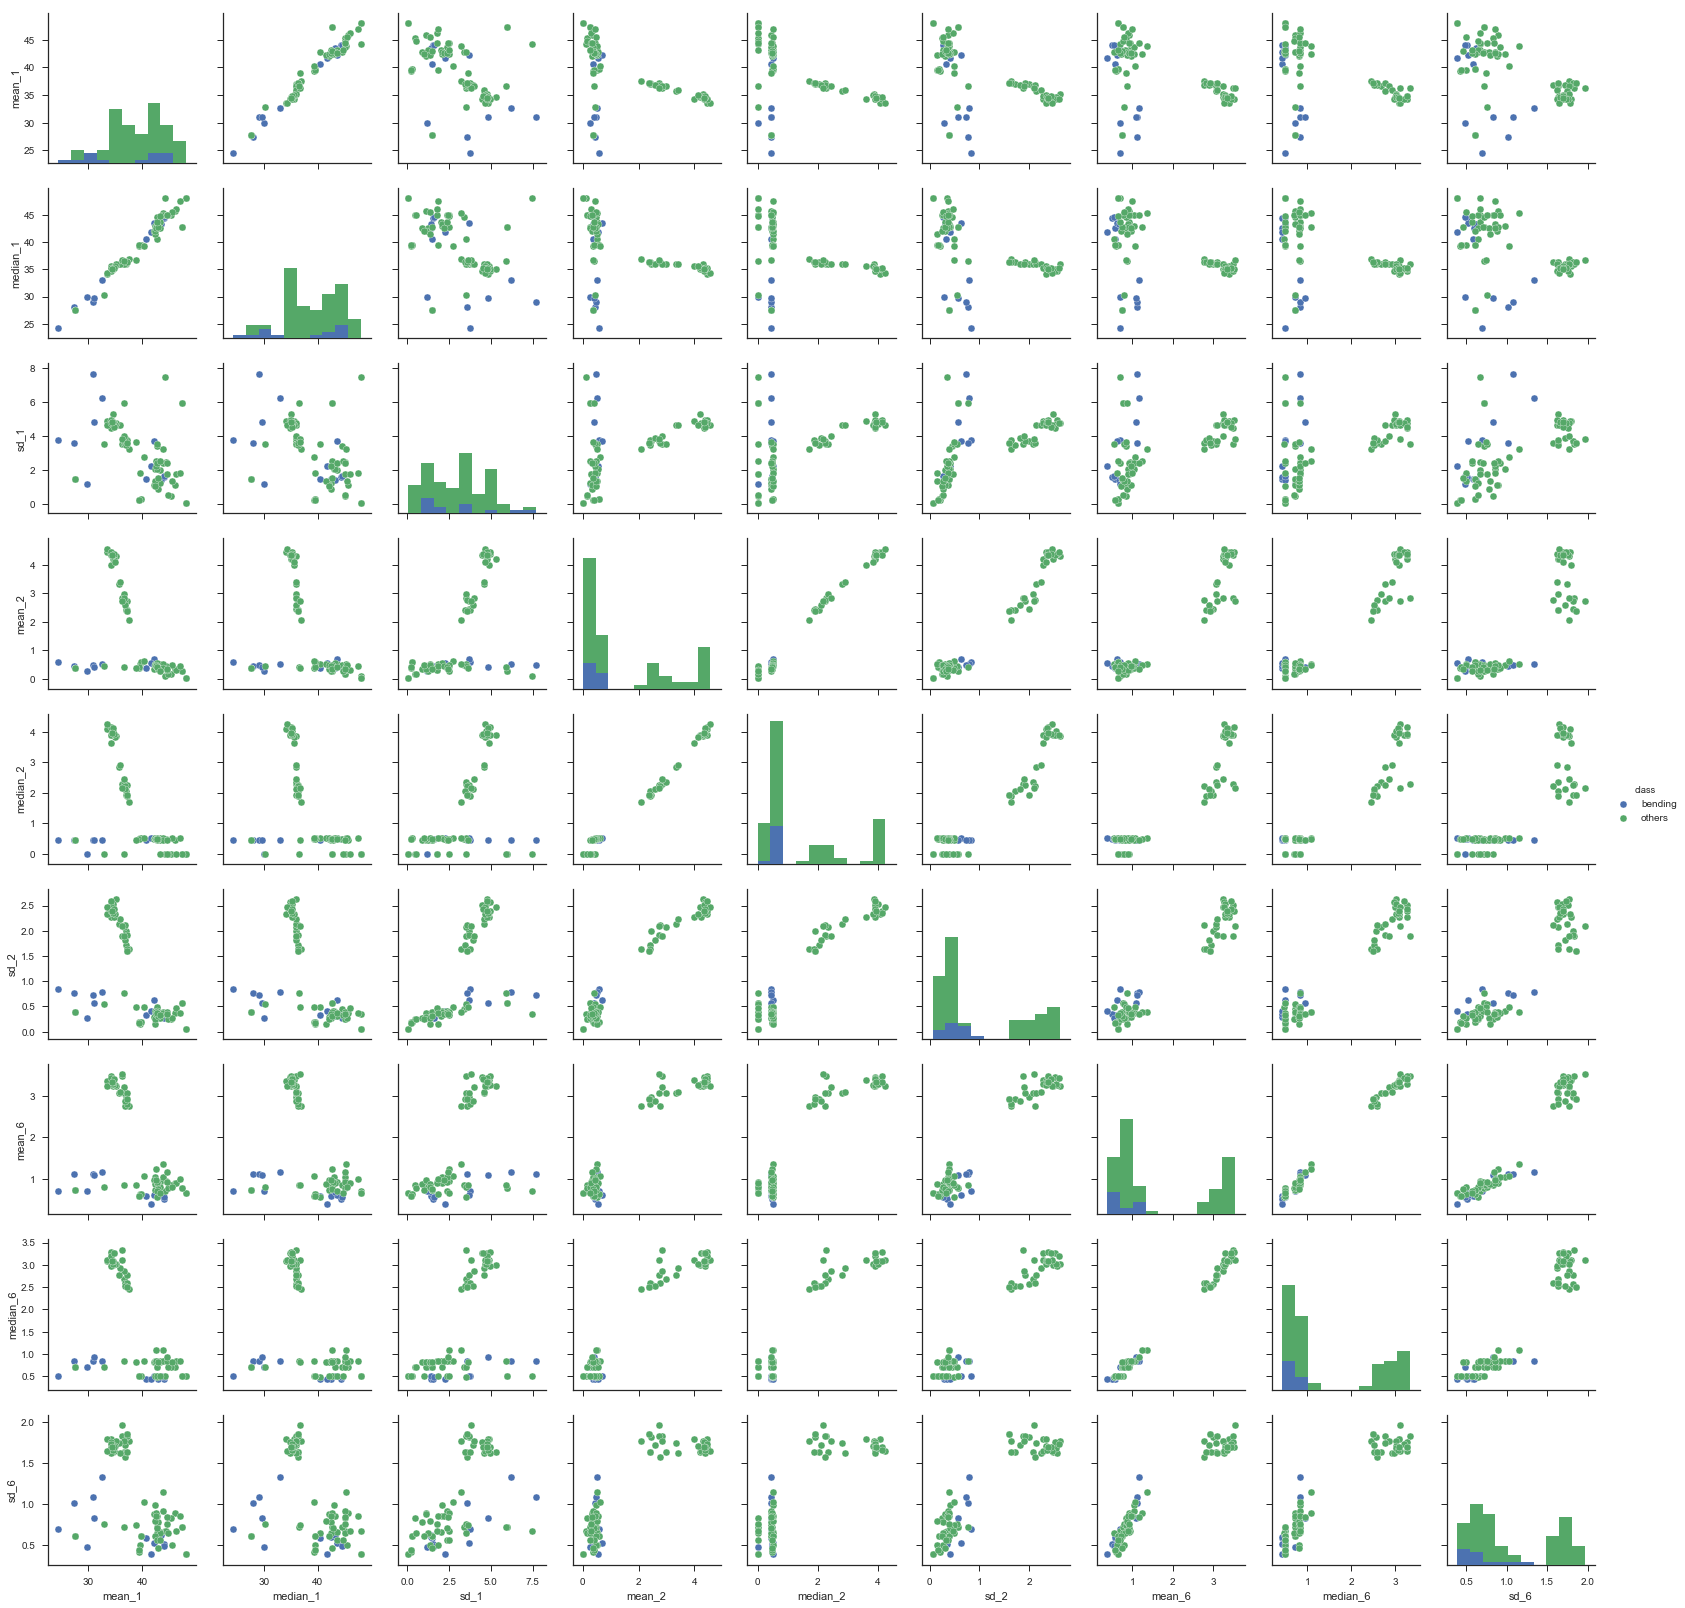

In [24]:
sns.set(style = "ticks", color_codes=True)
g = sns.pairplot(df_plot_time, hue="class")

### ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 1(d)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 12. Do you see any considerable difference in the results with those of 1(d)i?

In [25]:
def df_varies_i(df,l,df_time):
    
    df_varies = defaultdict(list)
    
    column_features = ["avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]
    time_domain_features = ['min','max','mean','median','sd','first_quart','third_quart']
    
    
    for no in range(df_time.shape[0] ):
        for i in range(l):
            for col,j in zip(column_features,range(1+(6*i),(len(column_features)*(i+1))+1)):
                for td_feature in time_domain_features:
                    iterate = (480//l)
                    if td_feature == "min":
                        if 480 + (480 * no) - (iterate + (iterate*i) + (480 * no)) >= iterate:
                            df_varies[td_feature+"_"+str(j)].append(df.iloc[0 + (iterate*i) + (480 * no): iterate + (iterate*i) + (480 * no)][col].min())
                        else:
                            df_varies[td_feature+"_"+str(j)].append(df.iloc[0 + (iterate*i) + (480 * no): 480 + (480 * no)][col].min())               
                    if td_feature == "max":
                        if 480 + (480 * no) - (iterate + (iterate*i) + (480 * no)) >= iterate:
                            df_varies[td_feature+"_"+str(j)].append(df.iloc[0 + (iterate*i) + (480 * no): iterate + (iterate*i) + (480 * no)][col].max())
                        else:
                            df_varies[td_feature+"_"+str(j)].append(df.iloc[0 + (iterate*i) + (480 * no): 480 + (480 * no)][col].max())                
                    if td_feature == "mean":
                        if 480 + (480 * no) - (iterate + (iterate*i) + (480 * no)) >= iterate:
                            df_varies[td_feature+"_"+str(j)].append(df.iloc[0 + (iterate*i) + (480 * no): iterate + (iterate*i) + (480 * no)][col].mean())
                        else:
                            df_varies[td_feature+"_"+str(j)].append(df.iloc[0 + (iterate*i) + (480 * no): 480 + (480 * no)][col].mean())                              
                    if td_feature == "median":
                        if 480 + (480 * no) - (iterate + (iterate*i) + (480 * no)) >= iterate:
                            df_varies[td_feature+"_"+str(j)].append(df.iloc[0 + (iterate*i) + (480 * no): iterate + (iterate*i) + (480 * no)][col].median())
                        else:
                            df_varies[td_feature+"_"+str(j)].append(df.iloc[0 + (iterate*i) + (480 * no): 480 + (480 * no)][col].median())                        
                    if td_feature == "sd":
                        if 480 + (480 * no) - (iterate + (iterate*i) + (480 * no)) >= iterate:
                            df_varies[td_feature+"_"+str(j)].append(df.iloc[0 + (iterate*i) + (480 * no): iterate + (iterate*i) + (480 * no)][col].std())
                        else:
                            df_varies[td_feature+"_"+str(j)].append(df.iloc[0 + (iterate*i) + (480 * no): 480 + (480 * no)][col].std())                        
                    if td_feature == "first_quart":
                        if 480 + (480 * no) - (iterate + (iterate*i) + (480 * no)) >= iterate:
                            df_varies[td_feature+"_"+str(j)].append(df.iloc[0 + (iterate*i) + (480 * no): iterate + (iterate*i) + (480 * no)][col].quantile(0.25))
                        else:
                            df_varies[td_feature+"_"+str(j)].append(df.iloc[0 + (iterate*i) + (480 * no): 480 + (480 * no)][col].quantile(0.25))                
                    if td_feature == "third_quart":
                        if 480 + (480 * no) - (iterate + (iterate*i) + (480 * no)) >= iterate:
                            df_varies[td_feature+"_"+str(j)].append(df.iloc[0 + (iterate*i) + (480 * no): iterate + (iterate*i) + (480 * no)][col].quantile(0.75))
                        else:
                            df_varies[td_feature+"_"+str(j)].append(df.iloc[0 + (iterate*i) + (480 * no): 480 + (480 * no)][col].quantile(0.75))
        df_varies['class'].append(df_time.iloc[no,-1])
    
    df_varies = pd.DataFrame(df_varies)
    
    return df_varies                                                               

In [26]:
df_time_2 = df_varies_i(df,2,df_time)
df_plot_time_2 = df_time_2[["mean_1","median_1","sd_1","mean_2","median_2","sd_2","mean_12","median_12","sd_12","class"]]

In [27]:
df_plot_time_2 = df_plot_time_2.replace(to_replace =["bending1","bending2" ],value ="bending")
df_plot_time_2 = df_plot_time_2.replace(to_replace = [var for var in activity if var != "bending1" or var != "bending2"],value="others")

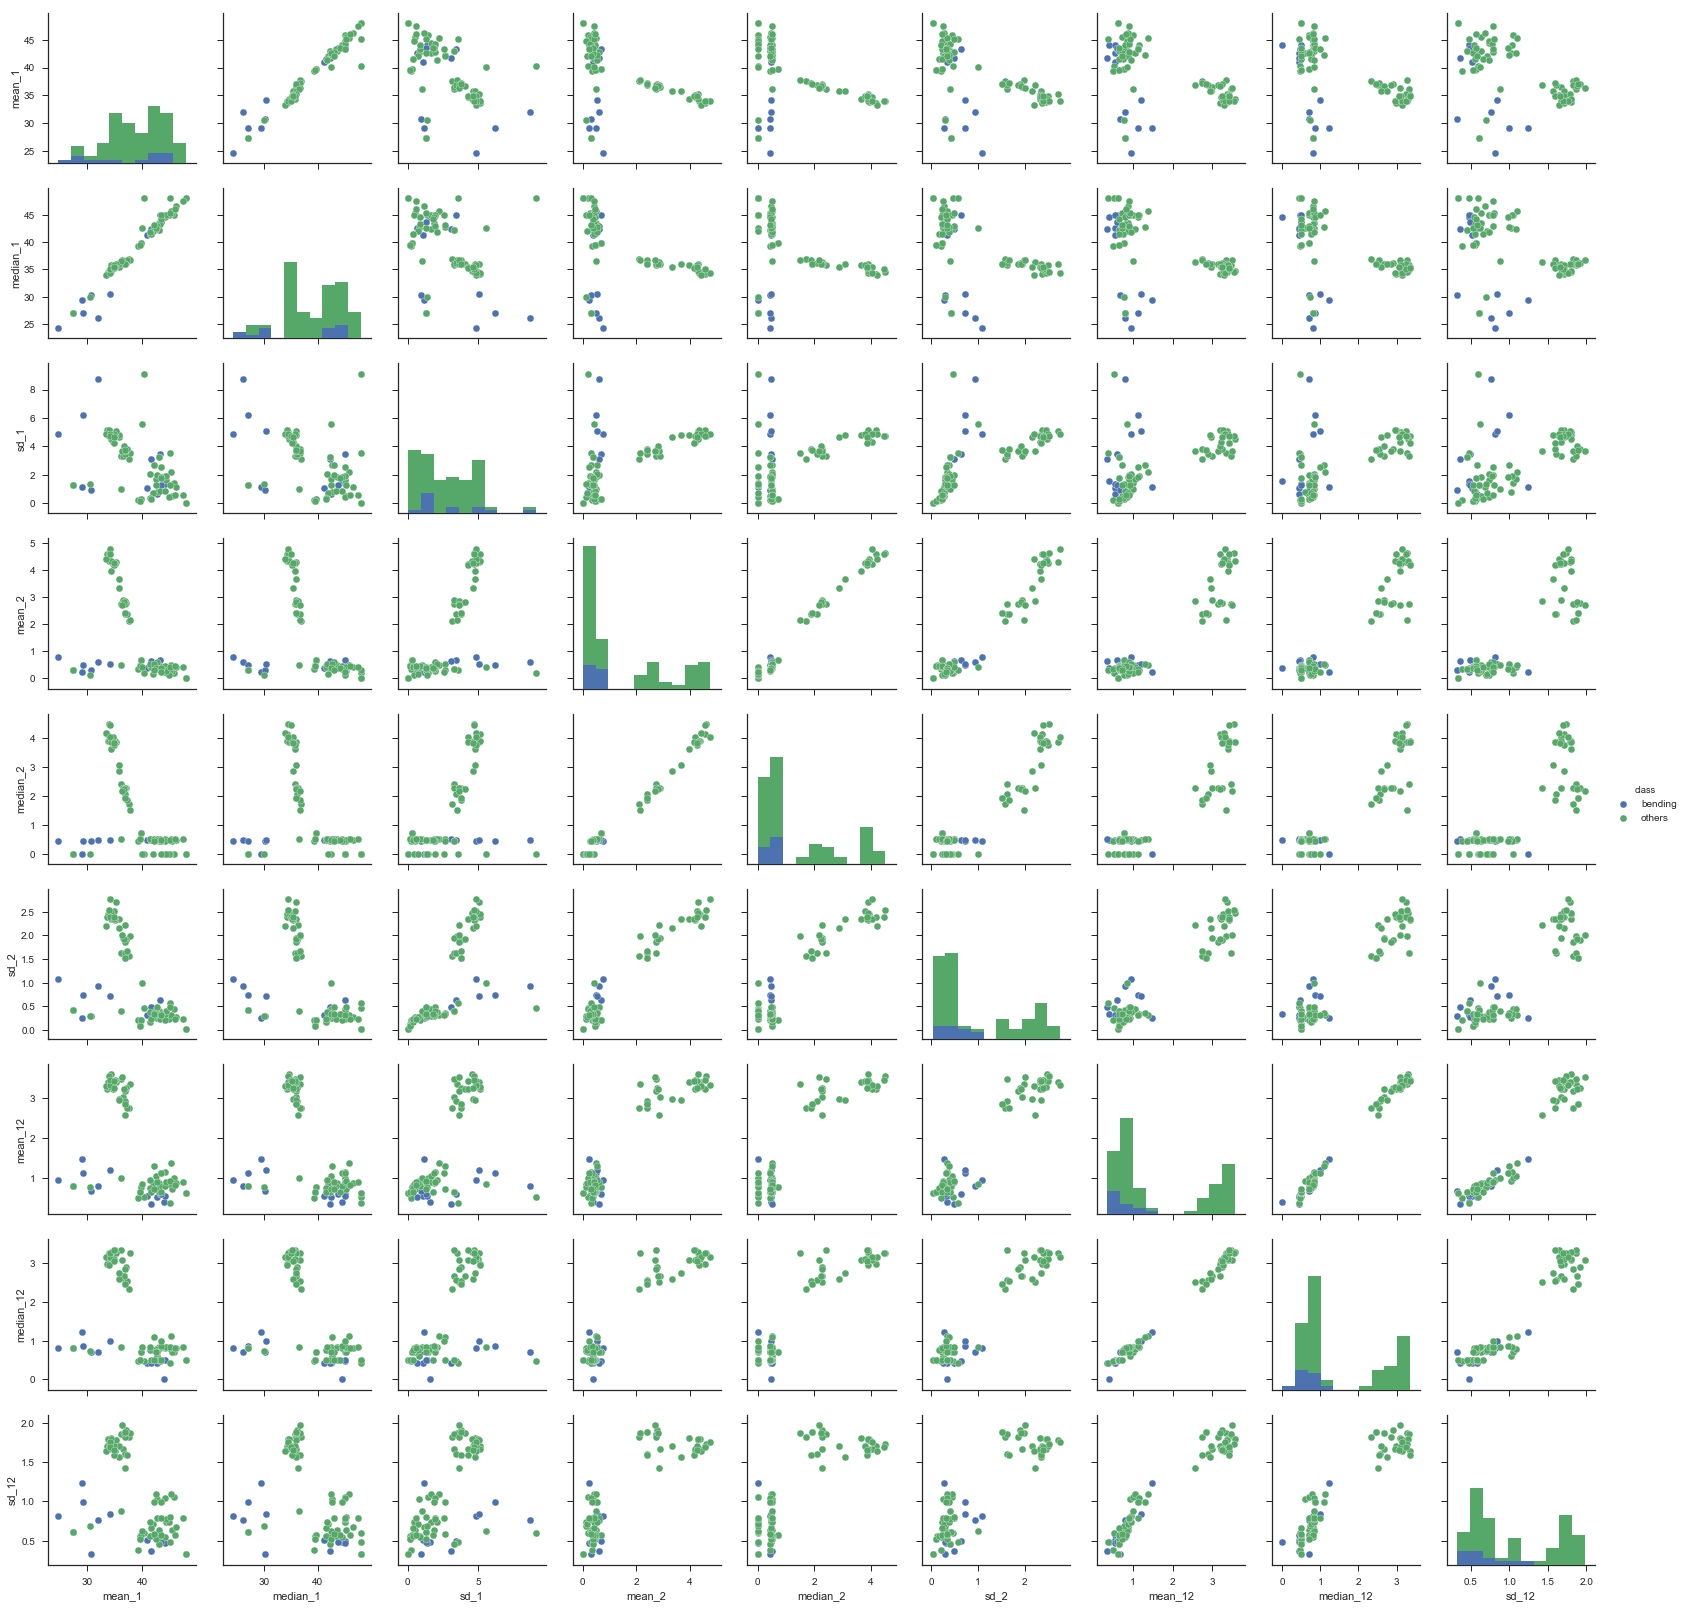

In [28]:
sns.set(style = "ticks", color_codes=True)
g = sns.pairplot(df_plot_time_2, hue="class")

I didn't see the consider difference for 1d(i) and 1d(ii). They look similar.

### iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features. Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.

##### In the following, you can see an example of applying Python’s Recursive Feature Elimination, which is a backward selection algorithm, to logistic regression.

In [47]:
# from sklearn . linear model import LogisticRegression # load the iris datasets
# dataset = datasets . load iris ()
# # create a base classifier used to evaluate a subset of attributesx
# model = LogisticRegression ()
# # create the RFE model and select 3 attributes
# rfe =RFE(model, 3)
# rfe = rfe.fit(dataset.data, dataset.target) # summarize the selection of the attributes
# print ( rfe . support   ) print(rfe.ranking )

In [100]:
best_iter_l_p = defaultdict(list)

for i in range(1,5):
    best_accuracy = -1
    n_features = -1
    l_num = -1
    for l in range(1,21):
        df_time_train_tmp = df_varies_i(df_train,l,df_time_train)
        X = df_time_train_tmp.drop("class",axis=1)
        y = df_time_train_tmp["class"]
        y = y.replace(to_replace =["bending1","bending2" ],value =1)
        y = y.replace(to_replace = [var for var in activity if var != "bending1" or var != "bending2"],value=0)
        logmodel = LogisticRegression(max_iter=i,C=1000000000)
        rfecv = RFECV(estimator=logmodel, step=1, cv=StratifiedKFold(5,shuffle=True,random_state=200),
                      scoring='accuracy',n_jobs=-1)
        rfecv.fit(X, y)
        if best_accuracy < max(rfecv.grid_scores_):
            best_accuracy = max(rfecv.grid_scores_)
            l_num = l
            n_features = rfecv.n_features_
    best_iter_l_p["max_iter"].append(i)
    best_iter_l_p["no. of l"].append(l_num)
    best_iter_l_p["no. of features used in RFE"].append(n_features)
    best_iter_l_p["best_accuracy"].append(best_accuracy)
    best_iter_l_p["error_rate"].append(1 - best_accuracy)
best_iter_l_p = pd.DataFrame(best_iter_l_p)
print(best_iter_l_p)

   max_iter  no. of l  no. of features used in RFE  best_accuracy  error_rate
0         1         1                           42       0.870330    0.129670
1         2         1                           42       0.870330    0.129670
2         3        14                            2       0.985714    0.014286
3         4        18                            7       1.000000    0.000000


The best (l,p) is (14,2) with the max_iter = 3. The error_rate = 0.014286. It's a right way.

### iv.) Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.


In [87]:
df_time_train_tmp = df_varies_i(df_train,14,df_time_train)
X = df_time_train_tmp.drop("class",axis=1)
y = df_time_train_tmp["class"]
y = y.replace(to_replace =["bending1","bending2" ],value =1)
y = y.replace(to_replace = [var for var in activity if var != "bending1" or var != "bending2"],value=0)
logmodel = LogisticRegression(max_iter=3,C=1000000000)
rfecv = RFECV(estimator=logmodel, step=1, cv=StratifiedKFold(5,shuffle=True,random_state=200),
                      scoring='accuracy',n_jobs=-1)
rfecv = rfecv.fit(X,y)

In [88]:
col_X_l_p = X.columns[rfecv.support_]
X_l_p = X[col_X_l_p]
logmodel.fit(X_l_p,y)
pred = logmodel.predict(X_l_p)
error_rate_X_l_p = 1 - accuracy_score(y,pred)
error_rate_X_l_p

0.08695652173913049

In [89]:
X.columns[rfecv.support_]

Index(['min_11', 'median_11'], dtype='object')

In [90]:
logmodel.coef_

array([[ 0.67085042, -0.53183378]])

In [93]:
accuracy_iv = accuracy_score(y,pred)
accuracy_iv

0.9130434782608695

In [68]:
confusion_matrix(y, pred)

array([[58,  2],
       [ 4,  5]])

True Positive = 5, True Negative = 58, False Positive = 2, False Negative = 4

AUC: 0.787


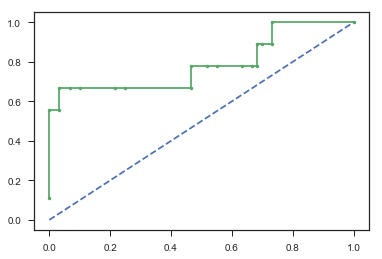

In [69]:
probs = logmodel.predict_proba(X_l_p)
probs = probs[:, 1]
auc = roc_auc_score(y, probs)
print('AUC: %.3f' % auc)
fpr, tpr, thresholds = roc_curve(y, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

In [70]:
stat_logmodel = sm.Logit(y,X_l_p)
stat_logmodel = stat_logmodel.fit(maxiter=3)
stat_logmodel.summary()

         Current function value: 0.332431
         Iterations: 3


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  class   No. Observations:                   69
Model:                          Logit   Df Residuals:                       67
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Jun 2019   Pseudo R-squ.:                  0.1415
Time:                        14:53:50   Log-Likelihood:                -22.938
converged:                      False   LL-Null:                       -26.718
                                        LLR p-value:                  0.005969
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
min_11         0.6305      0.164      3.845      0.000       0.309       0.952
median_11     -0.5352      0.129     -4.153      0.000      -0.788      -0.283
==============================================================================
"""

### v.) Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [71]:
df_time_test_tmp = df_varies_i(df_test,14,df_time_test)
X_test = df_time_test_tmp.drop("class",axis=1)
y_test = df_time_test_tmp["class"]
y_test = y_test.replace(to_replace =["bending1","bending2" ],value =1)
y_test = y_test.replace(to_replace = [var for var in activity if var != "bending1" or var != "bending2"],value=0)
X_test_l_p = X_test[col_X_l_p]
pred_X_test = logmodel.predict(X_test_l_p)

In [72]:
error_rate_X_test_l_p = 1 - accuracy_score(y_test,pred_X_test)

In [104]:
error_compare = pd.DataFrame(columns=["error_CV","error_test_set"])
error_compare.loc["value"] =  float(best_iter_l_p[best_iter_l_p["max_iter"]==3]["error_rate"]), error_rate_X_test_l_p

In [105]:
error_compare

,error_CV,error_test_set
value,0.014286,0.105263


### vi.) Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

Yes, I try to do the logistic regression without maxIter and then it shows well-separated. This is because it has a lot of features so, it's well-separated due to the few amount of data points.

### vii.) From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

I've seen the imbalanced class, around 12% (9/69) for class 1, it's so small. So, let's apply SMOTE.

In [41]:
smt = SMOTE()
X_smote, y_smote = smt.fit_sample(X_l_p, y)
logmodel.fit(X_smote,y_smote)
pred_smote = logmodel.predict(X_smote)
accuracy_smote = accuracy_score(y_smote,pred_smote)

In [42]:
confusion_matrix(y_smote, pred_smote)

array([[46, 14],
       [ 7, 53]])

True Positive = 54, True Negative = 46, False Positive = 14, False Negative = 6

AUC: 0.935


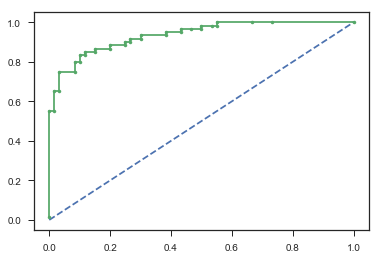

In [43]:
probs = logmodel.predict_proba(X_smote)
probs = probs[:, 1]
auc = roc_auc_score(y_smote, probs)
print('AUC: %.3f' % auc)
fpr, tpr, thresholds = roc_curve(y_smote, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

### (e) Binary Classification Using L1-penalized logistic regression
### i. Repeat 1(d)iii using L1-penalized logistic regression, i.e. instead of using p-values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.

In [78]:
# best_accuracy = -1
# n_features = -1
# l_num = -1

best_l1_log = defaultdict(list)

for l in range(1,21):
    best_accuracy = -1
    df_time_train_tmp = df_varies_i(df_train,l,df_time_train)
    X = df_time_train_tmp.drop("class",axis=1)
    y = df_time_train_tmp["class"]
    y = y.replace(to_replace =["bending1","bending2" ],value =1)
    y = y.replace(to_replace = [var for var in activity if var != "bending1" or var != "bending2"],value=0)
    logmodel_CV = make_pipeline(Normalizer(),LogisticRegressionCV(class_weight = 'balanced',penalty='l1',cv=StratifiedKFold(5,shuffle=True,random_state=200),solver="liblinear",max_iter = 2))    
    logmodel_CV.fit(X, y)
    pred_log_CV = logmodel_CV.predict(X)
    accuracy_score_log_CV = accuracy_score(y,pred_log_CV)
    best_l1_log["no. of l"].append(l)
    best_l1_log["best_accuracy"].append(accuracy_score_log_CV)
    best_l1_log["error_rate"].append(1 - accuracy_score_log_CV)


best_l1_log = pd.DataFrame(best_l1_log)
print(best_l1_log)

    no. of l  best_accuracy  error_rate
0          1       0.971014    0.028986
1          2       0.971014    0.028986
2          3       0.971014    0.028986
3          4       0.971014    0.028986
4          5       0.971014    0.028986
5          6       0.971014    0.028986
6          7       0.985507    0.014493
7          8       0.985507    0.014493
8          9       0.971014    0.028986
9         10       0.985507    0.014493
10        11       0.985507    0.014493
11        12       0.985507    0.014493
12        13       0.985507    0.014493
13        14       0.985507    0.014493
14        15       0.985507    0.014493
15        16       0.985507    0.014493
16        17       0.985507    0.014493
17        18       0.985507    0.014493
18        19       0.985507    0.014493
19        20       0.985507    0.014493


In [81]:
best_err_l1_log = min(best_l1_log["error_rate"])
best_err_l1_log

0.01449275362318836

The best l for L1-penalized is 6 with best error rate, 0.01449275362318836

### ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

In [96]:
error_compare = pd.DataFrame(columns=["error variable selection using p-values","error L1-penalized "])
error_compare.loc["value"] = (1-accuracy_iv) ,best_err_l1_log
error_compare

,error variable selection using p-values,error L1-penalized
value,0.086957,0.014493


Error L1-Penalized performs better. L1-penalized is easier to implement.

### (f) Multi-class Classification (The Realistic Case)
### i. Find the best l in the same way as you found it in 1(e)i to build an L1-penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [32]:
best_l1_log_multi = defaultdict(list)

pred_log_cv_best = []
max_score = []
best_accuracy = -1
n_features = -1
l_num = -1
for l in range(1,21):
    df_time_train_tmp = df_varies_i(df_train,l,df_time_train)
    X = df_time_train_tmp.drop("class",axis=1)
    y = df_time_train_tmp["class"]
    for k,v in enumerate(activity):
        y = y.replace(to_replace =[v],value = k+1)
    logmodel_CV = LogisticRegressionCV(penalty='l1',cv=5,solver="liblinear",multi_class = 'ovr')
    logmodel_CV.fit(X, y)

    df_time_test_tmp = df_varies_i(df_test,l,df_time_test)
    X_test = df_time_test_tmp.drop("class",axis=1)
    y_test = df_time_test_tmp["class"]
    for k,v in enumerate(activity):
        y_test = y_test.replace(to_replace =[v],value = k+1)


    pred_log_CV = logmodel_CV.predict(X_test)
    accuracy_score_log_CV = accuracy_score(y_test,pred_log_CV)
    if best_accuracy < accuracy_score_log_CV:
        best_accuracy = accuracy_score_log_CV
        l_num = l
        pred_log_cv_best = pred_log_CV
    
    best_l1_log_multi["no. of l"].append(l)
    best_l1_log_multi["best_accuracy"].append(accuracy_score_log_CV)
    best_l1_log_multi["error_rate"].append(1 - accuracy_score_log_CV)

best_l1_log_multi = pd.DataFrame(best_l1_log_multi)
print(best_l1_log_multi)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


    no. of l  best_accuracy  error_rate
0          1       0.684211    0.315789
1          2       0.736842    0.263158
2          3       0.684211    0.315789
3          4       0.684211    0.315789
4          5       0.789474    0.210526
5          6       0.736842    0.263158
6          7       0.736842    0.263158
7          8       0.789474    0.210526
8          9       0.789474    0.210526
9         10       0.736842    0.263158
10        11       0.736842    0.263158
11        12       0.736842    0.263158
12        13       0.789474    0.210526
13        14       0.736842    0.263158
14        15       0.736842    0.263158
15        16       0.789474    0.210526
16        17       0.736842    0.263158
17        18       0.736842    0.263158
18        19       0.736842    0.263158
19        20       0.789474    0.210526


In [42]:
print("best error for l1_log_multi: ", min(best_l1_log_multi["error_rate"]),"with l = 5")

best error for l1_log_multi:  0.21052631578947367 with l = 5


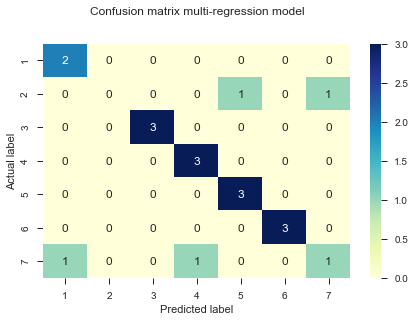

In [55]:
cm = confusion_matrix(y_test,pred_log_cv_best)
cm = pd.DataFrame(cm)
cm.index += 1 
sns.heatmap(cm,annot = True,cmap="YlGnBu", fmt="g",xticklabels=[1,2,3,4,5,6,7])
plt.tight_layout()
plt.title('Confusion matrix multi-regression model',y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

### ii.) Repeat 1(f)i using a Na ̈ıve Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.

In [106]:
best_gaussian = defaultdict(list)

for l in range(1,21):
    df_time_train_tmp = df_varies_i(df_train,l,df_time_train)
    X = df_time_train_tmp.drop("class",axis=1)
    y = df_time_train_tmp["class"]
    for k,v in enumerate(activity):
        y = y.replace(to_replace =[v],value = k+1)
    clf = GaussianNB()
    clf.fit(X, y)

    df_time_test_tmp = df_varies_i(df_test,l,df_time_test)
    X_test = df_time_test_tmp.drop("class",axis=1)
    y_test = df_time_test_tmp["class"]
    for k,v in enumerate(activity):
        y_test = y_test.replace(to_replace =[v],value = k+1)

    score_clf = clf.score(X_test,y_test)
    best_gaussian["no. of l"].append(l)
    best_gaussian["best_accuracy"].append(score_clf)
    best_gaussian["error_rate"].append(1 - score_clf)
    
    
best_gaussian = pd.DataFrame(best_gaussian)
print(best_gaussian)

    no. of l  best_accuracy  error_rate
0          1       0.894737    0.105263
1          2       0.631579    0.368421
2          3       0.736842    0.263158
3          4       0.789474    0.210526
4          5       0.789474    0.210526
5          6       0.631579    0.368421
6          7       0.736842    0.263158
7          8       0.736842    0.263158
8          9       0.684211    0.315789
9         10       0.789474    0.210526
10        11       0.684211    0.315789
11        12       0.631579    0.368421
12        13       0.736842    0.263158
13        14       0.578947    0.421053
14        15       0.578947    0.421053
15        16       0.526316    0.473684
16        17       0.526316    0.473684
17        18       0.684211    0.315789
18        19       0.473684    0.526316
19        20       0.578947    0.421053


In [107]:
best_multiNB = defaultdict(list)

for l in range(1,21):
    df_time_train_tmp = df_varies_i(df_train,l,df_time_train)
    X = df_time_train_tmp.drop("class",axis=1)
    y = df_time_train_tmp["class"]
    for k,v in enumerate(activity):
        y = y.replace(to_replace =[v],value = k+1)
    clf = MultinomialNB()
    clf.fit(X, y)

    df_time_test_tmp = df_varies_i(df_test,l,df_time_test)
    X_test = df_time_test_tmp.drop("class",axis=1)
    y_test = df_time_test_tmp["class"]
    for k,v in enumerate(activity):
        y_test = y_test.replace(to_replace =[v],value = k+1)

    score_clf = clf.score(X_test,y_test)
    best_multiNB["no. of l"].append(l)
    best_multiNB["best_accuracy"].append(score_clf)
    best_multiNB["error_rate"].append(1 - score_clf)
    
    
best_multiNB = pd.DataFrame(best_multiNB)
print(best_multiNB)

    no. of l  best_accuracy  error_rate
0          1       0.894737    0.105263
1          2       0.736842    0.263158
2          3       0.789474    0.210526
3          4       0.789474    0.210526
4          5       0.736842    0.263158
5          6       0.736842    0.263158
6          7       0.736842    0.263158
7          8       0.736842    0.263158
8          9       0.736842    0.263158
9         10       0.736842    0.263158
10        11       0.789474    0.210526
11        12       0.736842    0.263158
12        13       0.789474    0.210526
13        14       0.789474    0.210526
14        15       0.789474    0.210526
15        16       0.789474    0.210526
16        17       0.842105    0.157895
17        18       0.842105    0.157895
18        19       0.842105    0.157895
19        20       0.842105    0.157895


In [167]:
error_compare = pd.DataFrame(columns=["best error Gaussian priors","best error Multinomial priors"])
error_compare.loc["value"] = min(best_gaussian["error_rate"]), min(best_multiNB["error_rate"])
error_compare

,best error Gaussian priors,best error Multinomial priors
value,0.105263,0.105263


### iii.) Which method is better for multi-class classification in this problem?

In [168]:
error_compare_iii = pd.DataFrame(columns=["best error L1 multi-Regression","best error Gaussian priors","best error Multinomial priors"])
error_compare_iii.loc["value"] = float(best_l1_log_multi["error_rate"]),min(best_gaussian["error_rate"]), min(best_multiNB["error_rate"])
error_compare_iii

,best error L1 multi-Regression,best error Gaussian priors,best error Multinomial priors
value,0.210526,0.105263,0.105263


Choosing Na ̈ıve Bayes’ classifier (Both gaussian and multinomial priors) due to their error rates.

### 2. ISLR 3.7.4. I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regression model to the data, as well as a separate cubic regression, i.e. Y = β0 +β1X +β2X2 +β3X3 +ε.
### (a) Suppose that the true relationship between X and Y is linear, i.e. Y = β0 + β1X + ε. Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.
### (b) Answer (a) using test rather than training RSS.
### (c) Suppose that the true relationship between X and Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.
### (d) Answer (c) using test rather than training RSS.

(See in PDF.)

### 3. ISLR, 4.7.3 This problem relates to the QDA model, in which the observations within each class are drawn from a normal distribution with a class-specific mean vector and a class specific covariance matrix. We consider the simple case where p = 1; i.e. there is only one feature.
### Suppose that we have K classes, and that if an observation belongs to the kth class then X comes from a one-dimensional normal distribution, X ∼N(μk,σk2). Recall that the density function for the one-dimensional normal distribution is given in (4.11). Prove that in this case, the Bayes’ classifier is not linear. Argue that it is in fact quadratic.
### Hint: For this problem, you should follow the arguments laid out in Section 4.4.2, but without making the assumption that σ12 = . . . = σK2 

(See in PDF.)

### 4. ISLR 4.7.7 Suppose that we wish to predict whether a given stock will issue a dividend this year (“Yes” or “No”) based on X, last year’s percent profit. We examine a large number of companies and discover that the mean value of X for companies that issued a dividend was X ̄ = 10, while the mean for those that didn’t was X ̄ = 0. In addition, the variance of X for these two sets of companies was σˆ2 = 36. Finally, 80 % of companies issued dividends. Assuming that X follows a normal distribution, predict the probability that a company will issue a dividend this year given that its percentage profit was X = 4 last year.
### Hint: Recall that the density function for a normal random variable is f(x) = √ 1 e−(x−μ)2/2σ2 . You will need to use Bayes’ theorem.

(See in PDF.)